In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import tensorflow as tf

### Loading Data

In [3]:
df = pd.read_excel(r'C:\Users\khasy\OneDrive\Documents\GitHub\Projects\Assignment 1\Cars_Data_full.xlsx')
df

,Price,Age,KM,Fuel,HP,MC,Color,Auto,CC,Drs,...,AC,Comp,CD,Clock,Pwin,PStr,Radio,SpM,M_Rim,Tow_Bar
0,21000,26,31463,Petrol,195,0,Silver,0,1800,3,...,1,0,1,1,1,1,0,0,1,0
1,20000,23,43612,Petrol,195,0,Red,0,1800,3,...,1,1,0,1,1,1,0,1,1,0
2,19650,26,32191,Petrol,195,0,Red,0,1800,3,...,1,1,0,1,1,1,0,1,1,0
3,21550,32,23002,Petrol,195,1,Black,0,1800,3,...,1,1,1,1,1,1,0,1,1,0
4,22550,33,34133,Petrol,195,1,Grey,0,1800,3,...,1,1,1,1,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1362,7550,70,20546,Petrol,89,1,Blue,0,1300,3,...,0,0,0,1,1,1,0,1,0,0
1363,10895,73,19002,Petrol,89,0,Grey,0,1300,3,...,0,0,0,0,0,1,0,1,0,0
1364,8550,72,17018,Petrol,89,0,Blue,0,1300,3,...,0,0,0,0,0,1,0,0,0,0
1365,7300,71,16918,Petrol,89,1,Grey,0,1300,3,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info() #Checks the datatypes of the features
#Fuel has only two values: Petrol or Deisel - Can be converted to an integer using Binary encoding
#Color needs to converted to an integer using label encoding

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367 entries, 0 to 1366
Data columns (total 28 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Price    1367 non-null   int64 
 1   Age      1367 non-null   int64 
 2   KM       1367 non-null   int64 
 3   Fuel     1367 non-null   object
 4   HP       1367 non-null   int64 
 5   MC       1367 non-null   int64 
 6   Color    1367 non-null   object
 7   Auto     1367 non-null   int64 
 8   CC       1367 non-null   int64 
 9   Drs      1367 non-null   int64 
 10  Cyl      1367 non-null   int64 
 11  Grs      1367 non-null   int64 
 12  Wght     1367 non-null   int64 
 13  G_P      1367 non-null   int64 
 14  Mfr_G    1367 non-null   int64 
 15  ABS      1367 non-null   int64 
 16  Abag_1   1367 non-null   int64 
 17  Abag_2   1367 non-null   int64 
 18  AC       1367 non-null   int64 
 19  Comp     1367 non-null   int64 
 20  CD       1367 non-null   int64 
 21  Clock    1367 non-null   int64 
 22  

### Encoding Categorical Data

In [275]:
#Convert Fuel type to integer using binary encoding
Fuel_dict = {'Petrol': 1,
            'Diesel': 0} #Assign 1 & 0 for petrol and deisel respectively
df['Fuel_type'] = df.Fuel.map(Fuel_dict)

#Convert Color to integer using label encoding
new_lbl = LabelEncoder()
df['Color_code'] = new_lbl.fit_transform(df['Color'])
df_new = df.drop(['Fuel', 'Color'], axis = 1)

### Feature Selection

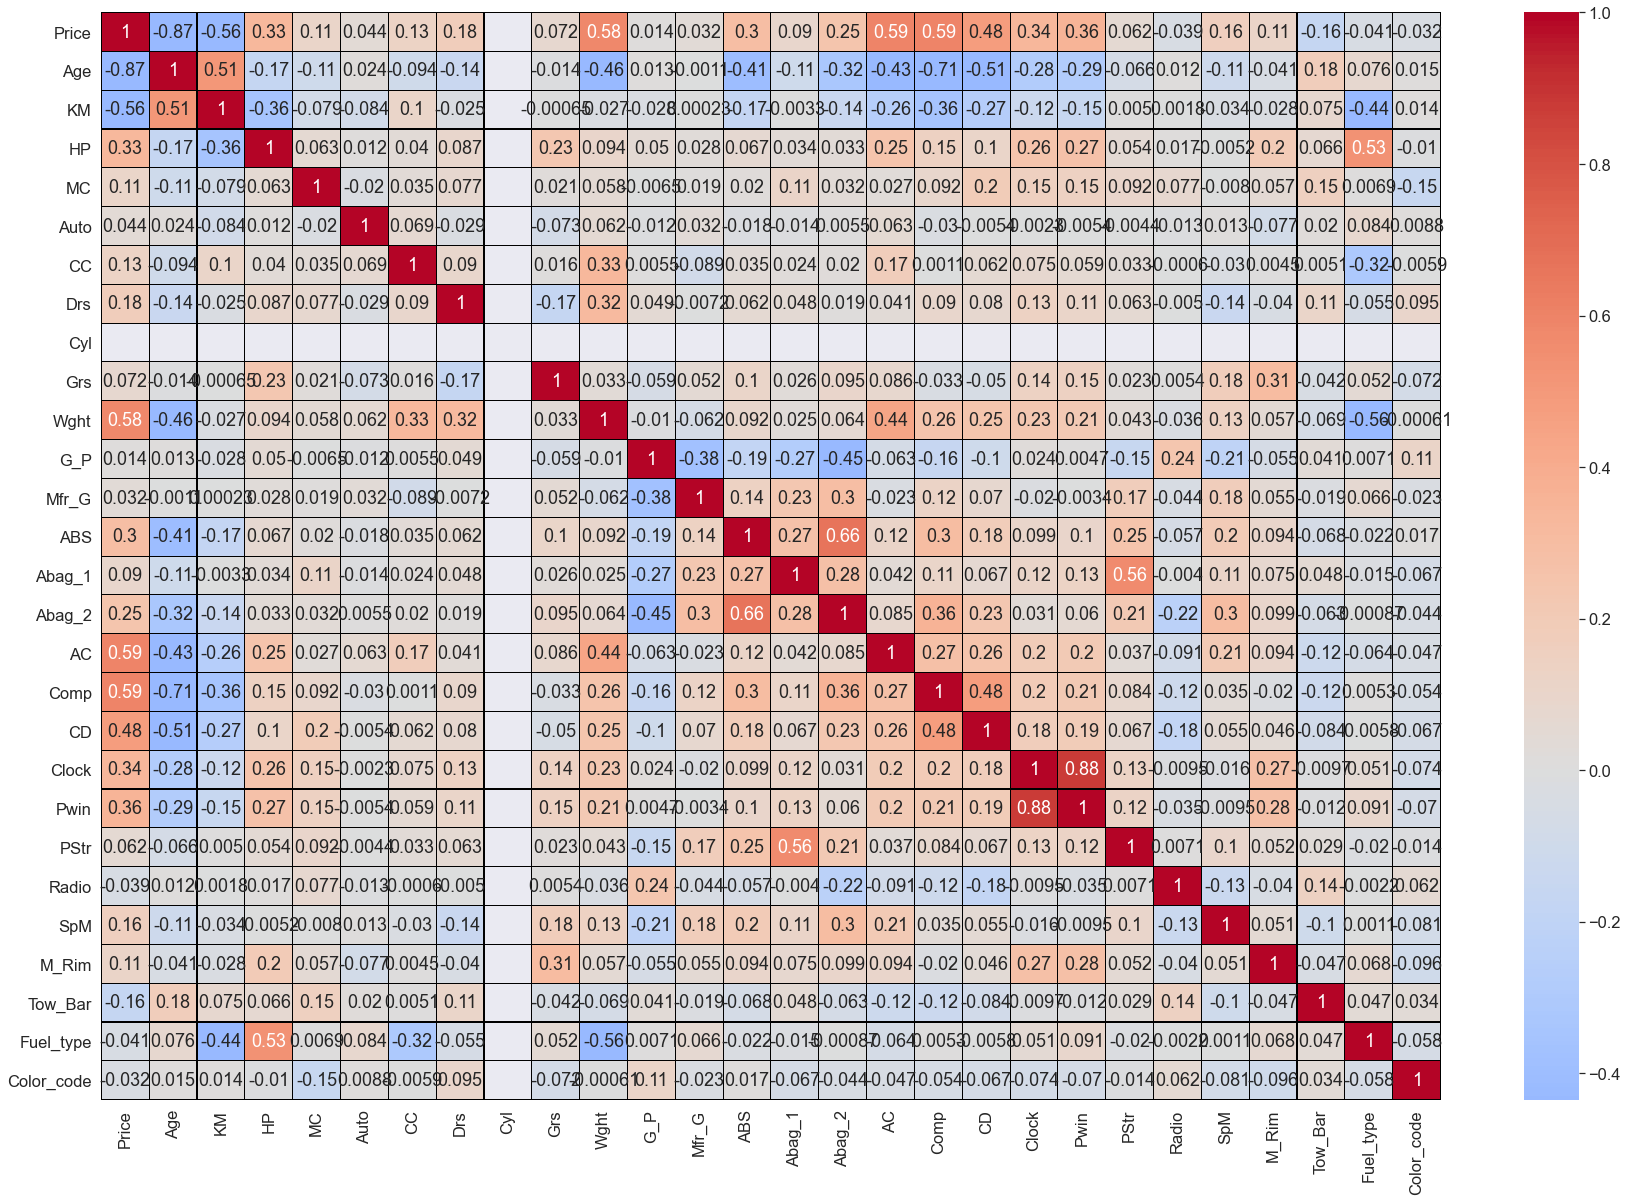

In [253]:
#Check for correlation between the features and the target variable using pearson correlation
correlation = df_new.corr(method='pearson')
#Plot the correlation matrix
plt.figure(figsize=(30,20))
sns.set(font_scale=1.5)
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, cmap='coolwarm', annot=True, 
            linewidths = 0.1, linecolor='black',robust = True, annot_kws={"size": 18}, center= 0)
#Sort the features in descending correlation 
features_sort = correlation.sort_values('Price',ascending = False)

In [276]:
# Normalize all values to bring them to a similar scale (Normalizing data brings all values to within 0 & 1)
x = df_new.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_new.loc[:,:] = x_scaled

#Establishing the features and the target parameters
X = df_new.drop(columns=['Price'])
y = df_new.Price

#Combining correlation and p-value test
lin_reg = sm.OLS(y,X).fit()
p = lin_reg.pvalues
p_df = pd.DataFrame(p)
p_df.columns = ['p_value']
correlation_new = correlation['Price'].copy()
correlation_new = correlation_new.drop(['Price'], axis =0)
corr_df = pd.DataFrame(correlation_new)
corr_df.columns = ['Correlation']
features_df = pd.concat([corr_df,p_df], axis = 1)

#Setting criterias for the features based on correlation and p_value
features_df = features_df.loc[(features_df['Correlation'] > 0.2) | (features_df['Correlation'] < -0.2) & (features_df['p_value'] < 0.05) ]

##Only Age, KM, Wght, AC and CD meet the criteria comfortably
features_df = features_df.drop(['HP','ABS','Abag_2','Comp','Clock','Pwin'], axis=0)
#Final features
df_new = df[['Age','KM','Wght','CD','AC']]
df_new

,Age,KM,Wght,CD,AC
0,26,31463,1189,1,1
1,23,43612,1189,0,1
2,26,32191,1189,0,1
3,32,23002,1189,1,1
4,33,34133,1189,1,1
...,...,...,...,...,...
1362,70,20546,1029,0,0
1363,73,19002,1019,0,0
1364,72,17018,1019,0,0
1365,71,16918,1019,0,0


### Model Preparation

In [278]:
#Establishing the features and the target parameters
X = df_new

#Splitting the data into training and testing (80% - Training and 20% - Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
len(X_train.columns)

#Cross-Validation grid serach
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
hyper_params = [{'n_features_to_select': list(range(1,6))}] #Range selected based on the number of features
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm) #Recursive Feature Elimination used as the estimator
model_cv = GridSearchCV(estimator = rfe,
                       param_grid = hyper_params,
                       scoring = 'r2',
                       cv = folds,
                       verbose = 1,
                       return_train_score = True)
model_cv.fit(X_train, y_train)

cv_result = pd.DataFrame(model_cv.cv_results_)
cv_result

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.006430,5.273280e-04,0.001892,2.233213e-04,1,{'n_features_to_select': 1},0.264352,0.312033,0.457340,0.453336,...,0.350312,0.087507,5,0.378138,0.361816,0.327390,0.327564,0.379708,0.354923,0.023269
1,0.006184,7.567488e-04,0.002407,5.047252e-04,2,{'n_features_to_select': 2},0.400634,0.419071,0.553248,0.572747,...,0.463428,0.082935,4,0.486624,0.477314,0.447001,0.440875,0.496132,0.469589,0.021859
2,0.004587,4.882093e-04,0.001995,2.780415e-07,3,{'n_features_to_select': 3},0.804126,0.794412,0.838735,0.862455,...,0.814239,0.032403,3,0.820702,0.821082,0.811700,0.804842,0.829782,0.817621,0.008576
3,0.003989,1.168008e-07,0.002001,1.386063e-05,4,{'n_features_to_select': 4},0.821926,0.805441,0.833605,0.873681,...,0.828164,0.025062,2,0.836199,0.838134,0.832722,0.822111,0.839763,0.833786,0.006291
4,0.004196,3.776573e-04,0.002193,3.998659e-04,5,{'n_features_to_select': 5},0.854102,0.822521,0.865039,0.898013,...,0.858041,0.024414,1,0.866113,0.871070,0.863243,0.854511,0.866523,0.864292,0.005496


### Linear Regression Model

In [279]:
#Based on the features selected, the grid search shows the the best result can be attained with all 5 features

#Establish linear regression model 
lin_reg_mod = LinearRegression()
lin_reg_mod.fit(X_train, y_train)

#Predict based on the linear regression model & metrics
pred = lin_reg_mod.predict(X_test)
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))
test_set_r2 = r2_score(y_test,pred)*100

print('The R^2 score is', test_set_r2)
print('The RMSE is', test_set_rmse)

The R^2 score is 89.55293130956404
The RMSE is 0.041333639410795424


### Neural Network Model